In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import math

In [2]:
def warpPerspectivePadded(
        imgl, H, imgr_shape):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    imgl : image to be warped i.e. left image
    imgr : shape of static image i.e. shape of central image
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    src = imgl
    dst_shape = imgr_shape
    M = H
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0],
        [1, 1]])
    # transform points
    transf_lin_pts = M.dot(lin_pts) #M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)
    transf_lin_pts /= transf_lin_pts[-1:,:]
    
    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    transl_transf = np.eye(3,3)
    if min_x < 0:
        anchor_x = -min_x
        transl_transf[0,2] = anchor_x
        
    shifted_transf = transl_transf.dot(M)
    shifted_transf /= shifted_transf[2,2]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + max(max_x, dst_w)
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped

In [3]:
# Read images to stitch
img1 = cv2.imread('left_.jpg')
img2 = cv2.imread('center_.jpg')
img3 = cv2.imread('right_.jpg')

#convert images from BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

#get image dimensions
h1, w1, _ = img1.shape
h2, w2, _ = img2.shape
h3, w3, _ = img3.shape

#### compute SIFT keypoints and corresponding descriptors for left and center images

In [4]:
# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift_obj.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift_obj.detectAndCompute(img2, None)

#### Find matching keypoints in two images and display the 20 best pairs

(Text(0.5, 1.0, 'Matched Keypoints'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

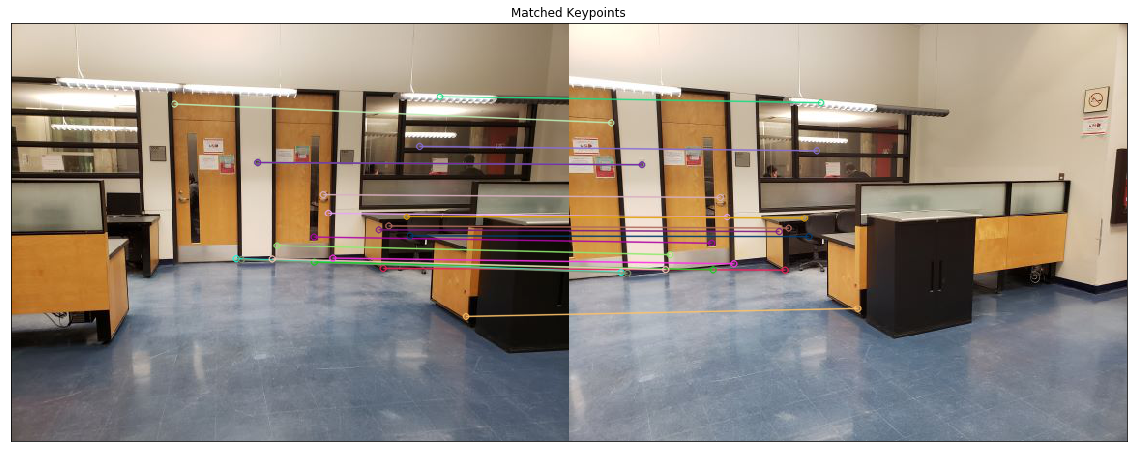

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_1,descriptors_2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(img1,keypoints_1,img2,keypoints_2, matches[:20], img1, flags=2)

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imgmatch)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])

#### Find homography using custom RANSAC method and apply warpPerspectivePadded method to left image

560 560
Found 106 inliers with an accuracy of 80
(433, 577, 3)
1154
433


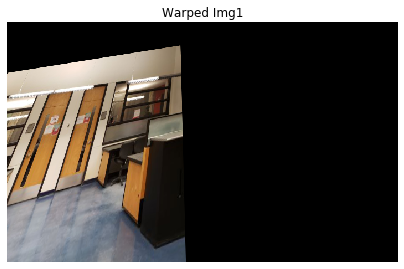

In [6]:
def RANSAC(mpl, mpr, N, acc):
    mpls = []
    mprs = []
    
    #random.seed(3)

    for i in range(N):
        rand = random.randrange(len(mpr))
        l = [mpl[rand]]
        r = [mpr[rand]]
        for i in range(5):
            rand = random.randrange(len(mpr))
            l.append(mpl[rand])
            r.append(mpr[rand])
        mpls.append(l)
        mprs.append(r)

    mpls = np.asarray(mpls)
    mprs = np.asarray(mprs)
    
    max_inliers = 0
    max_pos = 0

    #while(max_inliers < 100):
    for i in range(N):
        h, __ = cv2.findHomography(mpls[i], mprs[i], method=0)
        inliers = 0
        for k in range(len(mpl)):
            point = mpr[k]
            projectedPoint = np.matmul(h, np.append(mpl[k], [1]).transpose())
            distance = math.sqrt(((point[0]-projectedPoint[0])**2)+((point[1]-projectedPoint[1])**2))
            if distance < acc:
                inliers += 1
        if inliers > max_inliers:
            max_inliers = inliers
            max_pos = i
    #    acc += 1

    print("Found " + str(max_inliers) + " inliers with an accuracy of " + str(acc))
    
    h, __ = cv2.findHomography(mpls[max_pos], mprs[max_pos], method=0)

    mpli = []
    mpri = []

    for k in range(len(mpl)):
            point = mpr[k]
            projectedPoint = np.matmul(h, np.append(mpl[k], [1]).transpose())
            distance = math.sqrt(((point[0]-projectedPoint[0])**2)+((point[1]-projectedPoint[1])**2))
            if distance < acc:
                mpli.append(mpl[k])
                mpri.append(mpr[k])

    mpli = np.asarray(mpli)
    mpri = np.asarray(mpri)

    H, __ = cv2.findHomography(mpli, mpri, method=0)
    
    return H


# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mp2 = np.float32([keypoints_2[i].pt for (i, __) in GoodMatches])
mp1 = np.float32([keypoints_1[i].pt for (__, i) in GoodMatches])

print(len(mp2), len(mp1))

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(mp2)):
    mp2[i][0] += img2.shape[1]

    
#find homography
#M, _ = cv2.findHomography(mp1, mp2, cv2.RANSAC, 5)
M = RANSAC(mp2, mp1, 500, 80)


print(img2.shape)
print(w1+w2)
print(h2)
# Apply transformation to left image
#warped = cv2.warpPerspective(img1, M, (w1 + w2, h2))(h2, w1+w2, 3)
warped = warpPerspectivePadded(img1, M, img2.shape)

plt.figure(figsize=(7,7))
plt.imshow(warped)
plt.title("Warped Img1"), plt.axis('off')
plt.show()


#### stitch images together using pyramid blend

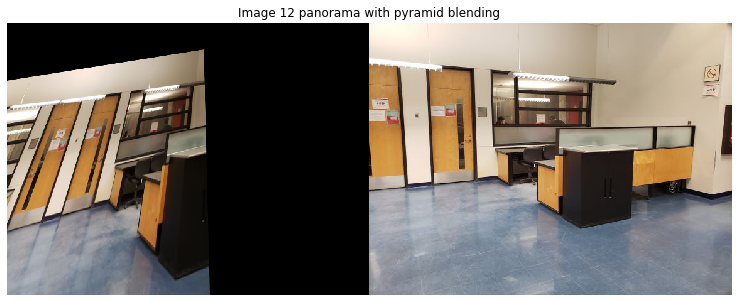

In [7]:
def pyramid_blend(A, B):
    
    levels = 1
    
    # Generate Gaussian pyramid for A and B
    gp_A = [A.copy()]
    for i in range(levels):
        gp_A.append(cv2.pyrDown(gp_A[-1]))
       
        
    # Generate Gaussian pyramid for B
    gp_B = [B.copy()]
    for i in range(levels):
        gp_B.append(cv2.pyrDown(gp_B[-1]))

    # Generate Laplacian Pyramids for A 
    lp_A  = [gp_A[levels-1]]
    for i in range(levels-1, 0, -1):
        hA, wA, _ = gp_A[i-1].shape
        GE = cv2.pyrUp(gp_A[i], dstsize=(wA, hA))
        L = cv2.subtract(gp_A[i-1], GE)
        lp_A.append(L)
        
        
    # Generate Laplacian Pyramids B
    lp_B  = [gp_B[levels-1]]
    for i in range(levels-1, 0, -1):
        hB, wB, _ = gp_B[i-1].shape
        GE = cv2.pyrUp(gp_B[i], dstsize=(wB, hB))
        L = cv2.subtract(gp_B[i-1], GE)
        lp_B.append(L)

    # Blend images at each level
    LS = []
    for la, lb in zip(lp_A, lp_B):
        ls = np.hstack((la, lb))
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1, levels):
        h, w, _ = LS[i].shape
        ls_ = cv2.pyrUp(blend, dstsize=(w, h))
        ls_ = cv2.add(blend, LS[i])

    return ls_.astype(np.uint8)

# Stitch warped hill1 and hill2 using pyramid blending
img_A = warped[:, :w1]
img_B = img2
img_12 = pyramid_blend(img_A, img_B)
h12, w12, _ = img_12.shape

# Display hill12
plt.figure(figsize=(20,5))
plt.imshow(img_12)
plt.title('Image 12 panorama with pyramid blending'), plt.axis('off')
plt.show()


#### Computer SURF keypoints and corresponding descriptors for stitched image and right image

In [8]:
# Get SURF features and descriptors
surf = cv2.xfeatures2d.SURF_create()
keypoints_12, descriptors_12 = surf.detectAndCompute(img_12, None)
keypoints_3, descriptors_3 = surf.detectAndCompute(img3, None)

#### Find matching keypoints in two images and display the 20 best pairs

(Text(0.5, 1.0, 'Matched Keypoints'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

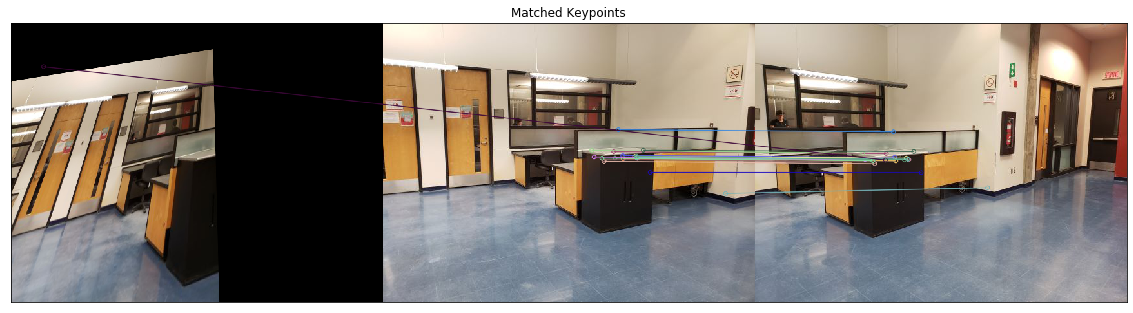

In [9]:
# Match descriptors.
matches = bf.match(descriptors_12,descriptors_3)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(img_12,keypoints_12,img3,keypoints_3, matches[:20], img_12, flags=2)

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(imgmatch)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])

#### Find homography using custom RANSAC method and apply warpPerspectivePadded method to right image

2905 2905


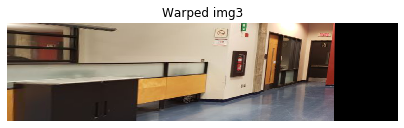

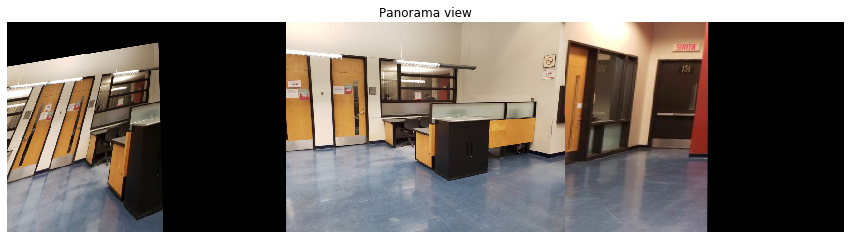

In [10]:
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mp2 = np.float32([keypoints_3[i].pt for (i, __) in GoodMatches])
mp1 = np.float32([keypoints_12[i].pt for (__, i) in GoodMatches])

print(len(mp2), len(mp1))

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(mp2)):
    mp2[i][0] += w12 + w3

# Get homography
M, _ = cv2.findHomography(mp1, mp2, cv2.RANSAC, 5)

# Apply transformation to right image 
warped = cv2.warpPerspective(img3, M, (w1 + w2 + w3, h2))

plt.figure(figsize=(7,7))
plt.imshow(warped)
plt.title("Warped img3"), plt.axis('off')
plt.show()

glued = warped.copy()
glued[:, :w12,:] = img_12
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Panorama view"), plt.axis('off')
plt.show()

#### Apply linear blending and display final image

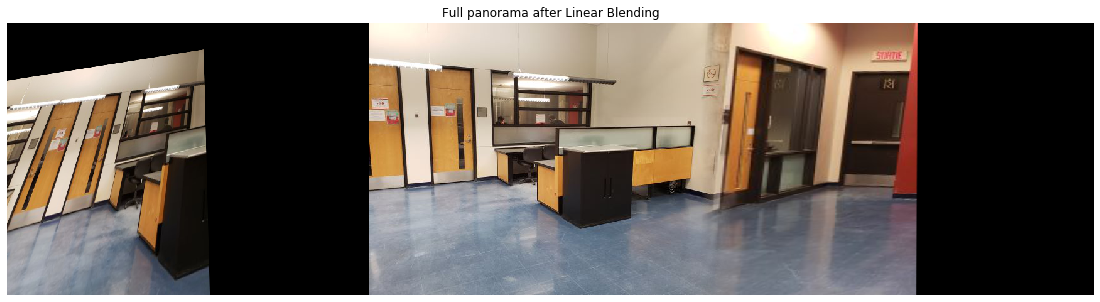

In [11]:
def linear_blend(i_width, r_width, r_index, start, end):
    
    res = np.zeros(i_width).astype(np.float)
    step = (end - start) / (r_width - 1)
    
    idx = r_index - r_width
    for i in range(r_width):
        res[idx] = start + step * i
        idx += 1
    res[idx:] = 1
    return res


# Stitch img12 and warped img3 
img_A = np.zeros((h12, w12 + w3, 3)).astype(np.uint8)
img_A[:, :w12, :] = img_12
img_B = warped
alpha = linear_blend(img_A.shape[1], 50, w12, 0, 1)

# Blend
img_123 = (1-alpha.reshape(1,-1,1)) * img_A + alpha.reshape(1,-1,1) * warped
img_123 = np.uint8(img_123)

h123, w123, _ = img_123.shape

# Display full image
plt.figure(figsize=(20,5))
plt.imshow(img_123)
plt.title('Full panorama after Linear Blending'), plt.axis('off')
plt.show()